In [48]:
import os
import shutil
import random
from PIL import Image
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from bertopic import BERTopic

from bertopic.representation import KeyBERTInspired
from bertopic.representation import PartOfSpeech
from bertopic.representation import MaximalMarginalRelevance

import sys
sys.path.insert(0, "../../")
sys.path.insert(0, "../../../hindsight/hindsight_server/")
from annotation_helpers import add_hindsight_frame_path, get_entity_image, visualize_annotations, get_entity_image
from annotations_db import HindsightAnnotationsDB

from db import HindsightDB
from utils import make_dir, ocr_results_to_str, add_datetimes

In [53]:
tweets_df = pd.read_csv("extracted_tweets_1.csv")
tweets_df = add_datetimes(tweets_df)

In [72]:
tweets_df.columns

Index(['parent_annotations_id', 'username', 'user_image', 'tweet_text',
       'tweet_image_content', 'image_content_source', 'retweets', 'replies',
       'likes', 'impresssions', 'time_since_post', 'user_handle',
       'verified_check', 'user_association_image', 'plus_button', 'ad_icon',
       'quoted_tweet', 'community_notes', 'more_posted',
       'user_retweeted_identifier', 'loading_icon', 'frame_id', 'timestamp',
       'datetime_utc', 'datetime_local', '5min_interval', 'datetime_to_day'],
      dtype='object')

In [77]:
tweets_df["ad_icon"] = tweets_df["ad_icon"].fillna(False)
tweets_df.loc[tweets_df['ad_icon']]

,parent_annotations_id,username,user_image,tweet_text,tweet_image_content,image_content_source,retweets,replies,likes,impresssions,...,community_notes,more_posted,user_retweeted_identifier,loading_icon,frame_id,timestamp,datetime_utc,datetime_local,5min_interval,datetime_to_day
144,1025,Jason McGhee,True,Nature of Code natureofcode.com,NaN,NaN,27,-1,1,I 14,...,NaN,NaN,NaN,NaN,383282.0,1726106946975,2024-09-12 02:09:06.974999905+00:00,2024-09-11 22:09:06.974999905-04:00,2024-09-11 22:06:27.395999908-04:00,2024-09-11 00:00:00-04:00
412,3036,Autism Capital &,True,"PETER THIEL TO JASON CALACANIS: ""We have to st...",True,NaN,1795,• 33,1.4K,Ill 294K,...,NaN,NaN,NaN,NaN,395367.0,1726322591860,2024-09-14 14:03:11.859999895+00:00,2024-09-14 10:03:11.859999895-04:00,2024-09-14 10:00:10.081000090-04:00,2024-09-14 00:00:00-04:00
489,134730,Real Name,True,Gave proof through the night that our flag was...,NaN,NaN,172.8K,@14,• 28.1,1 798K,...,NaN,NaN,NaN,NaN,29454.0,1717124566840,2024-05-31 03:02:46.839999914+00:00,2024-05-30 23:02:46.839999914-04:00,2024-05-30 23:00:16.880000114-04:00,2024-05-30 00:00:00-04:00
824,136204,gaut,True,this airpods feature,True,NaN,1789,@ 42,02.7K,Ill 650K,...,NaN,NaN,NaN,NaN,32845.0,1716831263594,2024-05-27 17:34:23.594000101+00:00,2024-05-27 13:34:23.594000101-04:00,2024-05-27 13:30:12.523000001-04:00,2024-05-27 00:00:00-04:00
1104,6858,ogug Women,True,"Women who gave the ""nice guy"" a chance how it ...",NaN,NaN,1711K,@ 480,© 10.6K,||| 6.1M,...,NaN,NaN,NaN,NaN,288521.0,1723592055278,2024-08-13 23:34:15.278000116+00:00,2024-08-13 19:34:15.278000116-04:00,2024-08-13 19:33:54.223000050-04:00,2024-08-13 00:00:00-04:00
1107,6894,Jemirox,True,Easy one-button • ation. View more: jemiro…um/YBG,True,NaN,179,-1,67,1| 354K,...,NaN,NaN,NaN,NaN,289296.0,1723544587969,2024-08-13 10:23:07.969000101+00:00,2024-08-13 06:23:07.969000101-04:00,2024-08-13 06:23:07.969000101-04:00,2024-08-13 00:00:00-04:00
1138,7056,Manish Kuma,True,Illegel Gadgets To Buy. Gadgets That Could Get...,True,NaN,17400,50,3.2K,-1,...,NaN,NaN,NaN,NaN,289803.0,1723566797040,2024-08-13 16:33:17.039999962+00:00,2024-08-13 12:33:17.039999962-04:00,2024-08-13 12:32:50.197999954-04:00,2024-08-13 00:00:00-04:00
1329,8021,ogug,True,"People were asked ""what disturbing sis you dis...",NaN,NaN,17657,• 159,8.9K,| 6.5M,...,NaN,NaN,NaN,NaN,293180.0,1723665184036,2024-08-14 19:53:04.036000013+00:00,2024-08-14 15:53:04.036000013-04:00,2024-08-14 15:52:41.499000072-04:00,2024-08-14 00:00:00-04:00
1360,8131,ogug Women,True,"Women who gave the ""nice guy"" a chance how it ...",NaN,NaN,174.7K,@1.3K,© 64.4K,||| 22.9M,...,NaN,NaN,NaN,NaN,293482.0,1723639531430,2024-08-14 12:45:31.430000067+00:00,2024-08-14 08:45:31.430000067-04:00,2024-08-14 08:45:25.154000044-04:00,2024-08-14 00:00:00-04:00
1369,8161,ogug Women,True,"Women who gave the ""nice guy"" a chance how it ...",NaN,NaN,174.7K,@1.3K,© 64.3K,||| 22.9M,...,NaN,NaN,NaN,NaN,293549.0,1723639527223,2024-08-14 12:45:27.223000050+00:00,2024-08-14 08:45:27.223000050-04:00,2024-08-14 08:45:25.154000044-04:00,2024-08-14 00:00:00-04:00


In [54]:
tweets_df['datetime_to_day'] = tweets_df['datetime_local'].dt.floor('D')

<Axes: xlabel='datetime_to_day'>

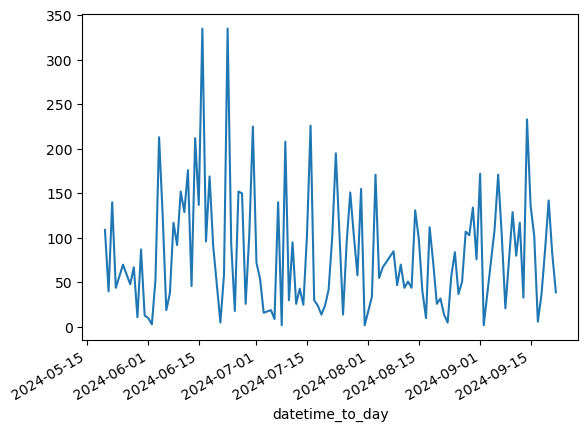

In [55]:
tweets_df.groupby(['datetime_to_day']).username.count().plot()

In [56]:
main_representation = KeyBERTInspired()

# Additional ways of representing a topic
aspect_model1 = PartOfSpeech("en_core_web_sm")
aspect_model2 = [KeyBERTInspired(top_n_words=30), MaximalMarginalRelevance(diversity=.5)]

# Add all models together to be run in a single `fit`
representation_model = {
   "Main": main_representation,
   "Aspect1":  aspect_model1,
   "Aspect2":  aspect_model2 
}
topic_model = BERTopic(representation_model=representation_model)

In [57]:
tweets_df = tweets_df.dropna(subset=['tweet_text'])
tweets_df = tweets_df.drop_duplicates(subset=['tweet_text'], keep="first")

In [58]:
topics, probs = topic_model.fit_transform(tweets_df['tweet_text'])

In [59]:
topic_info = topic_model.get_topic_info()

In [60]:
topic_info

,Topic,Count,Name,Representation,Aspect1,Aspect2,Representative_Docs
0,-1,2915,-1_show_but_man_see,"[show, but, man, see, they, actually, me, you,...","[more, people, man, about, time, video, years,...","[show, man, or, that, why, day, get, my, them,...",[Another example of why there's no winners in ...
1,0,230,0_kamala_kamalas_harris_dana,"[kamala, kamalas, harris, dana, kamalaharris, ...","[interview, campaign, black, president, more, ...","[kamala, harris, cnn, campaign, walz, intervie...",[Collin Rugg @ @CollinRugg • 22h BREAKING: Kam...
2,1,202,1_gaza_hamas_palestinian_palestinians,"[gaza, hamas, palestinian, palestinians, israe...","[muslim, islamic, hostages, people, children, ...","[palestinians, hezbollah, zionist, isis, netan...","[Israel has a right to finish Hamas., Kazim Kh..."
3,2,199,2_biden_bidens_joe_barack,"[biden, bidens, joe, barack, obama, vice, pres...","[president, press, race, reporter, conference,...","[biden, barack, reporter, 2020, donald, debate...","[Is Joe Biden Dead?, joe biden is doing WHAT??..."
4,3,165,3_shes_herself_she_her,"[shes, herself, she, her, espresso, woman, mar...","[woman, girlfriend, espresso, girl, relationsh...","[shes, espresso, margot, choreography, chick, ...",[I'm so fucking dumb i'm just realizing that t...
...,...,...,...,...,...,...,...
125,124,11,124_ohtani_umpire_shohei_baseball,"[ohtani, umpire, shohei, baseball, pitch, mlb,...","[base, umpire, mph, pitch, shit, male, glove, ...","[ohtani, umpire, shohei, baseball, base, crank...",[no way Shohei Ohtani celebrated a stolen base...
126,125,11,125_lungs_cigarettes_smoking_smoked,"[lungs, cigarettes, smoking, smoked, smokers, ...","[lungs, cigarettes, pack, joint, day, breath, ...","[cigarettes, ageing, 52yearold, genetics, park...",[These are the blackened lungs of a 52-year-ol...
127,126,10,126_blending_sophistication_designermotion_styles,"[blending, sophistication, designermotion, sty...","[variety, sophistication, coupling, electronic...","[blending, sophistication, designermotion, ani...","[Blending style and sophistication, Replying t..."
128,127,10,127_screamed_diagnosis_rabies_spasms,"[screamed, diagnosis, rabies, spasms, terrifyi...","[condition, medical, rabies, update, house, fl...","[screamed, rabies, spasms, terrifying, symptom...",[It really creeped me out because I was pre ce...


In [61]:
doc_info = topic_model.get_document_info(tweets_df['tweet_text'])

In [62]:
doc_info = doc_info.merge(tweets_df, left_on="Document", right_on=tweets_df['tweet_text'])

In [63]:
now_utc = datetime.utcnow()

time_start = (now_utc - timedelta(days=10)).replace(hour=0, minute=0, second=0, microsecond=0)

In [64]:
doc_info_filtered = doc_info.loc[doc_info['datetime_local'].dt.date >= time_start.date()]

In [65]:
grouped = doc_info_filtered.groupby('Name').resample('D', on='datetime_local').size().unstack(fill_value=0)

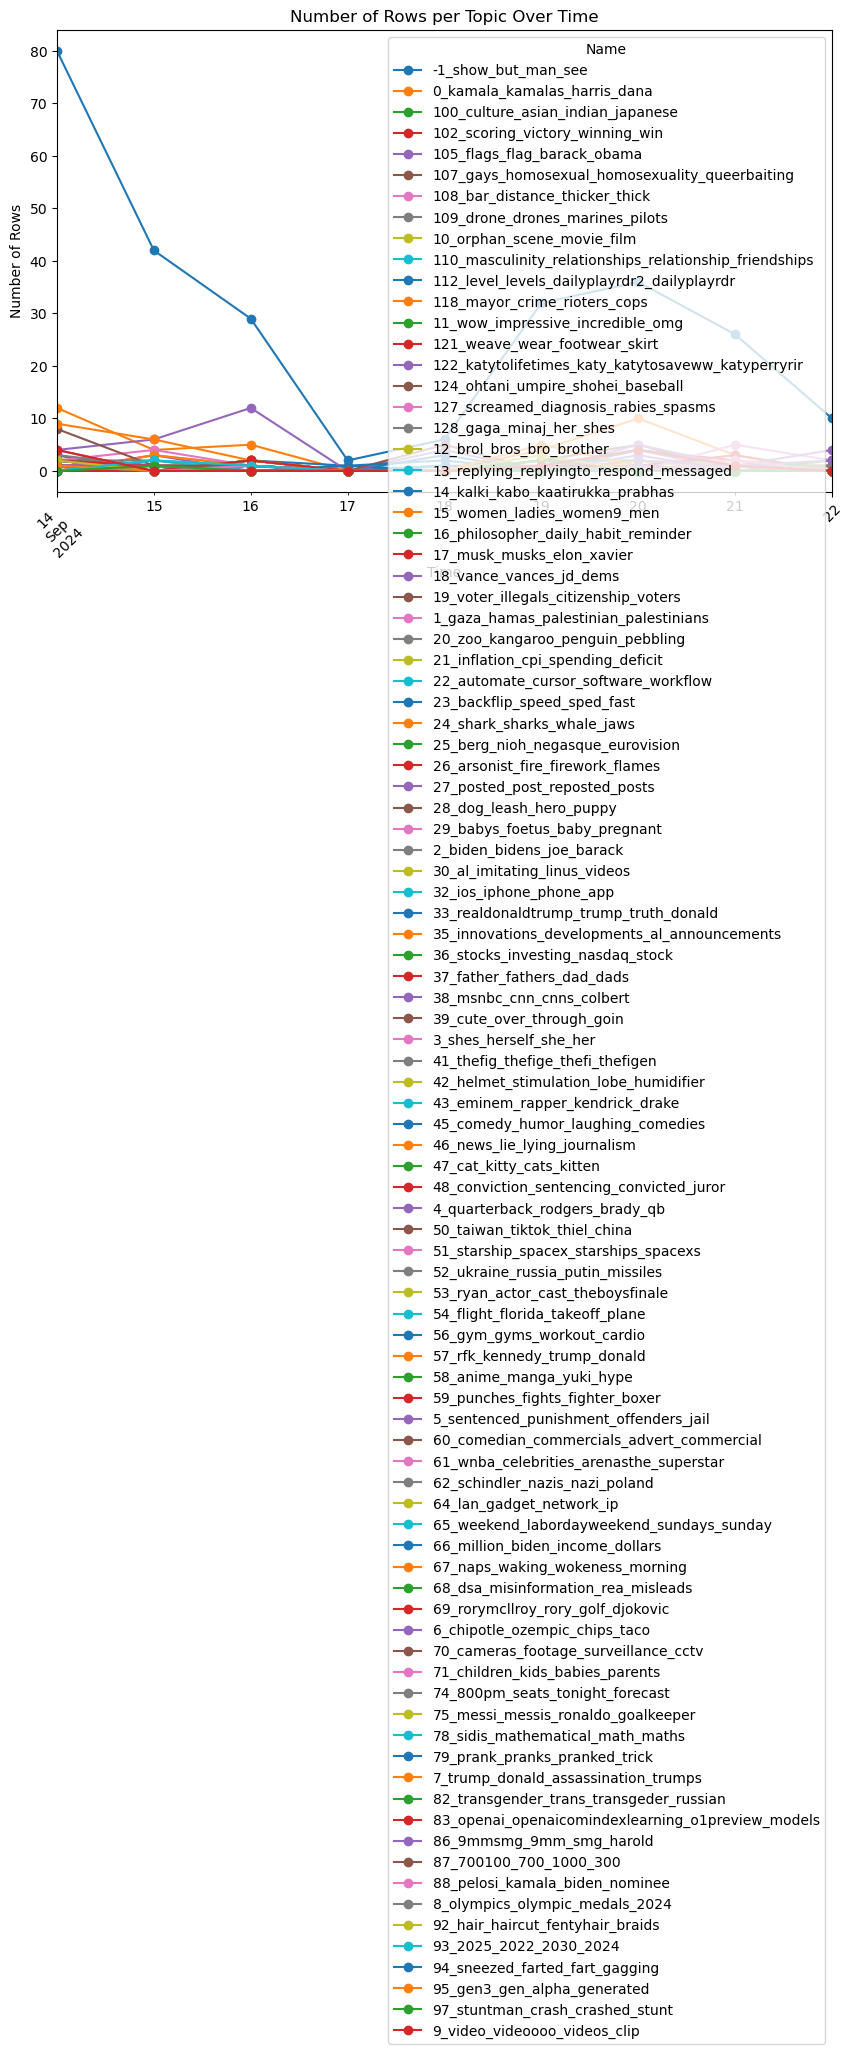

In [66]:
ax = grouped.T.plot(kind='line', figsize=(10, 6), marker='o')
ax.set_title('Number of Rows per Topic Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Number of Rows')
# ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [67]:
doc_info.loc[doc_info['Topic'] == 3]['Document'].iloc[0]

'She needs to leave his ass FAST It was a highway to nowher'

In [68]:
for d in doc_info.loc[doc_info['Topic'] == 3]['Document']:
    print(d)

She needs to leave his ass FAST It was a highway to nowher
She needs to leave his ass FAST It was a highway to nowhere and
She needs to leave his ass FAST
Updating my CV and trying to find out where to add my girl cause she's my highest achievement
This switch up is wild She's so joyful
Groom sees his best friend in wedding dress
Looks like she has 0 energy. Faking the "joy" must be exhausting.
broke her ego
She a calm 42
WHO IS SHE AND WHICH FIVE GUYS RESTAURANT DOES SHE WORK AT??
This little boy gave his address out to a random man he met on Roblox.. rinn She's very hot. Does she know that I coming
The way she tries to keep a smiling face when people are around her so they can have a cute moment but deep inside she is tired and wants to rest. I love you. The barbz love you. We appreciate you so much. Thank you thank you thank you for giving us a tour, and a second leg. More Show more
i wonder where she is now
Poor girl went to prom by herself
Laughing at making an old woman fall and 